# Complex networks: theory and applications
## Assignment 4: Barabasi-Albert graph

#### Andrea Senacheribbe

---

In [1]:
figpath="figures/"

In [2]:
import numpy as np
import scipy.sparse as sparse, scipy.sparse.csgraph as sgraph, scipy.sparse.linalg as slinalg
import scipy.stats as stats
import matplotlib.pyplot as plt, matplotlib.cm as cm
import numba as nb
import pandas as pd

In [3]:
@nb.njit
def duplicate(a, b):
    for i in a:
        if i==b:
            return True
    return False

@nb.njit
def choice_nr(size, p, sum_p):

    cdf = np.zeros(p.size, dtype=np.float64)

    i=0
    j=0
    cdf[0]=p[0]
    
    choices=np.empty(size, dtype=np.uint)
    
    while i<size:
        r=np.random.random()*sum_p
        
        if r<cdf[j]:
            new = np.searchsorted(cdf[:j+1], r, side='right')
        else:
            while cdf[j]<r:
                j+=1
                cdf[j]=cdf[j-1]+p[j]
            new = j
            
        if not duplicate(choices[0:i], new):
            choices[i]=new
            i+=1
    
    return choices

In [4]:
@nb.njit
def generate_BA_opt(n, m):
    
    ia=np.empty(n+1, dtype=np.uint)
    ja=np.empty(m*n, dtype=np.uint)   #actually (-m**2-m+2*m*n)/2
        
    assert(n>m)


    ia[0]=0
    ia[1]=0
    u=1
  
    urn=np.empty(2*m*n, dtype=np.uint)
    urn_len=0
    
    # create the starting graph: clique
    n_edg=0
    while u<m+1:
        ia[u+1]=ia[u]+u
        ja[n_edg:n_edg+u]=np.arange(u)
  
        urn[urn_len:urn_len+m]=u
        urn_len+=m
        
        n_edg+=u
        u+=1
        
    assert(u==m+1)
    assert(n_edg==(m*(m+1))/2)
    

    # now PA
    
    choice_s=np.empty(m, dtype=np.uint)

    while u<n:
        ia[u+1]=ia[u]+m

        k=0
        while k<m:
            choice_s[k]=urn[np.random.randint(urn_len)]
            if not duplicate(choice_s[:k], choice_s[k]):
                k+=1
                
        
        for c_i, c in enumerate(choice_s):
            ja[n_edg+c_i]=c
            urn[urn_len+c_i]=c
            
        urn_len+=m
        urn[urn_len:urn_len+m]=u
        urn_len+=m
        
        n_edg+=m        
        u+=1
        
    assert(n_edg<n*m)
    return n_edg, ia, ja[0:n_edg]

In [5]:
@nb.njit
def generate_BA(n, m, f):
    
    ia=np.empty(n+1, dtype=np.uint)
    ja=np.empty(m*n, dtype=np.uint)   #actually (-m**2-m+2*m*n)/2
    
    assert(n>m)
    
    
    f_m=f(m)
    
    d_u=np.full(n, m, dtype=np.uint)
    p_u=np.full(n, f_m, dtype=np.float64)
    
    ia[0]=0
    ia[1]=0
    u=1
  
    
    # create the starting graph: clique
    n_edg=0
    while u<m+1:
        ia[u+1]=ia[u]+u
        ja[n_edg:n_edg+u]=np.arange(u)
        
        n_edg+=u
        u+=1
        
    assert(u==m+1)
    assert(n_edg==(m*(m+1))/2)
    
    #
    
    # now PA
    
    sum_p_u=(m+1)*f_m
    
    while u<n:
        ia[u+1]=ia[u]+m

        choice_s=choice_nr(size=m, p=p_u[0:u], sum_p=sum_p_u)

        for c_i,c in enumerate(choice_s):
            ja[n_edg+c_i]=c
            sum_p_u-=p_u[c]
            
            d_u[c]+=1
            p_u[c]=f(d_u[c])
            sum_p_u+=p_u[c]
        
        sum_p_u+=f_m
        n_edg+=m
        u+=1
        
        
    assert(n_edg<n*m)
    return n_edg, ia, ja[0:n_edg]


def BA(n, m_ba, f=None):
    if f==None:
        m,ia,ja=generate_BA_opt(n, m_ba)
    else:
        m,ia,ja=generate_BA(n, m_ba, f)
        
    graph=sparse.csr_matrix((np.ones(m,dtype=np.uint8), ja, ia), shape=(n,n), dtype=np.uint8)

    return graph+graph.T.tocsr()

## Displaying some statistics about the graph


In [6]:
n=1000
m_ba=4
graph=BA(n,m_ba)
m=graph.nnz/2

In [7]:
print("n =", n, "(vertices)") 
print("m =", m, "(edges)")

n = 1000 (vertices)
m = 3990.0 (edges)


Plot the **sparsity** of the **adjacency matrix**

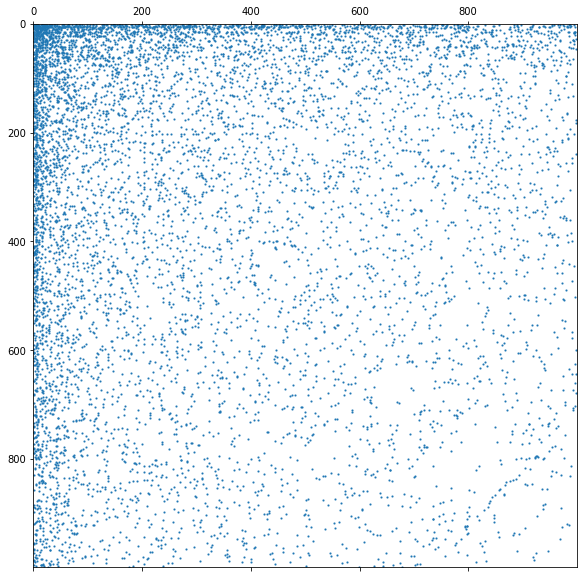

In [8]:
plt.figure(figsize=(10,10))
plt.spy(graph, markersize=1);
plt.savefig(figpath+"sparsity.png")

## Testing properties

In [9]:
@nb.njit
def clustering_coeff(n, ia, ja, n_trials):
    
    l=0

    for i in range(n_trials):
        v=np.random.randint(n)
        
        adj=ja[ia[v]:ia[v + 1]]
        assert(adj.size>=2)
        
        nodes=np.random.choice(adj, size=2, replace=False)
        for j in ja[ia[nodes[0]]:ia[nodes[0] + 1]]:
            if j==nodes[1]:
                l+=1
                break
            
        
    return l/n_trials

In [10]:
@nb.njit
def max_dst_bfs(n, ia, ja, head_node):
    NULL_IDX=-9999

    node_list=np.zeros(n, dtype=np.int64)
    predecessors=np.full(n, NULL_IDX, dtype=np.int64)
    distances=np.zeros(n, dtype=np.int64)

    node_list[0] = head_node
    i_nl = 0
    i_nl_end = 1
    
    while i_nl < i_nl_end:
        pnode = node_list[i_nl]
        adj=ja[ia[pnode]:ia[pnode + 1]]
        for cnode in adj:
            if (cnode == head_node):
                continue
            elif (predecessors[cnode] == NULL_IDX):
                node_list[i_nl_end] = cnode
                predecessors[cnode] = pnode
                distances[cnode]=distances[pnode]+1
                i_nl_end += 1

        i_nl += 1
    return np.max(distances)

@nb.njit
def diameter_approx(n,ia,ja, diameter_test):
    diameter=0
    diameter_test_points=np.random.choice(n, size=diameter_test,replace=False)
    
    for i in diameter_test_points:
        diameter=max(diameter, max_dst_bfs(n,ia,ja,i))
        
    return diameter
    

In [11]:
@nb.njit
def f15(x):
    return x**1.5

@nb.njit
def f05(x):
    return x**0.5


fun_s=[None, f05, f15]
fun_l=[1, 0.5, 1.5]


In [ ]:
n_gen=100
diameter_test=20
clustering_test=50000
n=100000
m_ba=3


df=pd.DataFrame(columns=["n", "fun", "diameter", "clustering", "degree", "deg_max"])

for fun_i, fun in enumerate(fun_s):
    print("\n-----\nexponent=", fun_l[fun_i],"\n-----\n")
    
    degree=np.zeros(n, dtype=np.float64)
    diameter=0
    clustering=0
    for i in range(n_gen): # montecarlo
        graph=BA(n, m_ba, fun)

        # degree distrib
        val, counts=np.unique(graph.sum(axis=1).A1, return_counts=True)
        degree[val]+=counts.astype(np.uint)

        # diameter
        diameter+=diameter_approx(n, graph.indptr, graph.indices, diameter_test)

        #clustering coeff
        clustering+=clustering_coeff(n, graph.indptr, graph.indices, clustering_test)


    deg_max=min(degree.size, np.max(degree.nonzero())+1)
    degree=degree[0:deg_max]
    assert(np.sum(degree)==n*n_gen)
    degree/=n_gen

    assert(diameter!=np.inf)

    df=df.append({"n": n,  "fun": fun_l[fun_i], "diameter": diameter/n_gen, "clustering":clustering/n_gen, "degree": degree, "deg_max":deg_max},ignore_index=True)


print("\n\n-------")

In [ ]:
df

In [ ]:
df.to_pickle("./results.pkl")